In [1]:
import json
import random

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage

In [27]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

## PCA code originally in `BJA-3.5.1.1` 

In [142]:
scaled = StandardScaler().fit_transform(data[data_cols].T)
pca_object = PCA(n_components=10).fit(scaled)
pca = pca_object.transform(scaled)
pc_columns = [f'pc{x}' for x in range(1, pca_object.n_components+1)]
pca = pd.DataFrame(pca, index=data_cols, columns=pc_columns)
pca = pca.join(fg[['animal', 'bg_type', 'week']])
pca['animal'] = pca['animal'].astype('str')
pca = pca.rename({'bg_type': 'Sampling'}, axis=1)
pca['Sampling'] = pca['Sampling'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_), 
                        index=data.index, columns=pc_columns)
loadings['pc1_rank'] = loadings['pc1'].abs().rank(ascending=False)
loadings['pc2_rank'] = loadings['pc2'].abs().rank(ascending=False)
loadings = loadings.join(data['ID'])
loadings.loc[loadings['ID'] != 'unknown'].sort_values('pc2_rank').iloc[:20]

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc1_rank,pc2_rank,ID
i,,,,,,,,,,,,,
l_818,0.035793,-0.977774,0.050935,0.141403,-0.063749,-0.014514,-0.057572,-0.038770,0.023809,0.031880,1339.0,1.0,TG 56:5
l_707,-0.042370,-0.975300,-0.001451,0.145667,0.061614,-0.052568,-0.020265,-0.089295,-0.004403,0.015699,1330.0,2.0,Unidentified
l_708,0.039514,-0.973393,-0.000679,0.119720,-0.053543,-0.034129,-0.015620,-0.070103,-0.065799,0.002723,1336.0,3.0,TG 56:7
l_628,-0.003957,-0.973035,-0.000523,0.109196,-0.101536,-0.070400,0.057627,-0.024797,-0.046590,0.007725,1408.0,4.0,Unidentified
l_686,-0.030739,-0.970940,0.041434,0.040173,-0.122585,-0.025190,0.008026,-0.086872,-0.009151,0.027129,1348.0,5.0,TG 58:9
l_671,-0.169556,-0.966459,0.011141,0.057338,-0.056464,-0.054301,-0.003085,-0.073681,-0.046677,-0.001469,1112.0,6.0,TG 56:8
l_819,-0.051818,-0.965328,0.076322,0.166158,-0.076225,-0.039076,-0.022870,-0.021409,0.012455,0.068098,1311.0,7.0,Unidentified
l_820,-0.029645,-0.964930,0.071249,0.130334,-0.104393,0.028531,-0.029702,-0.043572,-0.020315,0.064064,1354.0,8.0,Unidentified
l_734,0.075773,-0.964360,-0.005076,0.175165,0.096365,-0.050336,0.004968,-0.074495,0.062089,0.027950,1279.0,9.0,TG 52:4


In [143]:
# Draw confidence intervals around data: 
# From https://stackoverflow.com/a/25022642
def make_ci(x, y, std=2, **kwargs):
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    w, h = 2 * std * np.sqrt(vals)
    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)), width=w, height=h, angle=theta, 
                      **kwargs)
    return ellipse

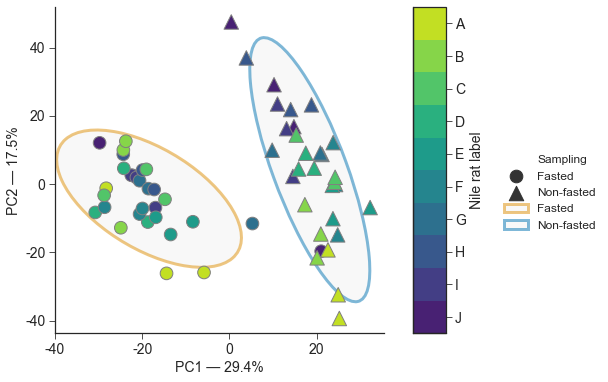

In [155]:
colors['Fasted'] = colors['FBG']
colors['Non-fasted'] = colors['RBG']
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot(
    data=pca, x='pc1', y='pc2', hue='animal', palette=colors,
    style='Sampling', markers={'Non-fasted': '^', 'Fasted': 'o'}, 
    size='Sampling', sizes={'Non-fasted': 210, 'Fasted':160},
    legend=True, alpha=1, linewidth=1, edgecolor='gray',
    ax=ax)
ax.set_xlabel(f'PC1 — {round(100*pca_object.explained_variance_ratio_[0], 1)}%', fontsize=14) 
ax.set_ylabel(f'PC2 — {round(100*pca_object.explained_variance_ratio_[1], 1)}%', fontsize=14) 
ax.tick_params(labelsize=14)
ax.set_xlim(-40, ax.get_xlim()[1])
# plt.legend(loc=(1.4, 0), fontsize=14, markerscale=2)

# Discrete colorbar 
# https://stackoverflow.com/a/48269806  code source
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.4)
cmap = ListedColormap(sns.color_palette('viridis', 10))
norm = BoundaryNorm(np.arange(0, 10 + 1) - 0.5, 10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax, shrink=0.2)
# cax.set_xlabel('data label') 
cb.ax.set_yticks(range(10), labels=[_ for _ in 'JIHGFEDCBA'], fontsize=14)
# cb.ax.set
cb.ax.set_ylabel('Nile rat label', fontsize=14)

for bg_type in ['Fasted', 'Non-fasted']:
    df = pca.loc[pca['Sampling'] == bg_type]
    ci_ellipse = make_ci(x=df['pc1'], y=df['pc2'], 
                         edgecolor=colors[bg_type], 
                         facecolor=(0.95, 0.95, 0.95),
                         linewidth=3, alpha=0.5, zorder=0, 
                         label=bg_type,
                        )
    ax.add_artist(ci_ellipse)
# plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[11:], labels=labels[11:], loc=(1.35, 0.3), title_fontsize=12, fontsize=12)
sns.despine()
# plt.savefig('../reports/figures/Figure2/PCA.pdf', dpi=150, bbox_inches='tight')

# Clustermap of all data
## Original heatmap code from `BJA-4.3.2-RvsF`
## Better code from `BJA-4.5.5-FigTGs-heatmap`

In [6]:
cm_data = data.loc[:, fg.index].T
# cm_data = cm_data.groupby(['animal', 'bg_type']).mean()
# cm_data = cm_data.reset_index()

# Normalize the data to the average of the lipid or metabolite across all fasted samples 
fbg_means = data.loc[:, fbg_cols].mean(axis=1)
cm_data = cm_data.subtract(fbg_means)
cm_data = cm_data.join(fg[['animal', 'bg_type']])
# Sort into correct order and add metadata for column colors 
# file_order = fg.sort_values(['bg_type', 'ogtt', 'week'], ascending=[True, True, True])
cm_data = cm_data.join(ap['OGTT (AUC)'], on='animal')
cm_data = cm_data.sort_values(['bg_type', 'OGTT (AUC)'])
cm_data['animal_color'] = cm_data['animal'].astype('str').map(colors)
cm_data

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,l_914,l_915,l_916,l_917,l_918,l_919,animal,bg_type,OGTT (AUC),animal_color
combined_col_name,,,,,,,,,,,,,,,,,,,,,
1091_8_FBG,0.238399,0.002571,0.891893,0.371912,3.144489,0.088486,0.035941,-0.256733,0.073236,0.353464,...,-1.568027,-0.710072,-1.864972,-0.639582,-0.685412,-0.521302,1091,FBG,19060.0,"[0.283072, 0.130895, 0.449241]"
1091_9_FBG,-0.038210,1.600206,-0.263899,0.429072,3.413428,1.494378,1.197328,1.767548,1.362814,1.457743,...,1.606351,0.464681,1.355214,0.126344,0.038838,-0.275253,1091,FBG,19060.0,"[0.283072, 0.130895, 0.449241]"
1091_10_FBG,-0.885422,-0.201320,0.294113,0.197481,2.789409,0.155941,0.155938,0.188853,0.073782,-0.167922,...,-0.252171,-0.223808,-0.204927,0.420468,0.220019,0.636626,1091,FBG,19060.0,"[0.283072, 0.130895, 0.449241]"
1093_8_FBG,-2.034620,0.125131,0.259371,0.131454,3.031694,0.161679,0.083738,0.211733,0.048941,0.398208,...,0.954661,0.225860,2.002863,1.602694,1.627976,1.921959,1093,FBG,25057.5,"[0.262138, 0.242286, 0.520837]"
1093_9_FBG,-0.200072,0.100451,-0.920178,0.010957,2.677643,0.201864,0.008949,0.542142,0.012250,0.335393,...,2.087874,1.284124,2.640129,1.816525,1.653919,1.826483,1093,FBG,25057.5,"[0.262138, 0.242286, 0.520837]"
1093_10_FBG,-0.431931,-0.361805,-0.584554,-0.111033,2.382439,0.083900,0.243498,0.346250,0.306790,-0.063877,...,0.319059,-0.103490,0.479363,0.403576,0.437443,0.497207,1093,FBG,25057.5,"[0.262138, 0.242286, 0.520837]"
1092_8_FBG,-1.883794,-0.277367,0.192726,0.183171,1.091578,-0.257738,-0.500350,0.498313,-0.603723,0.024000,...,-0.449420,-0.747410,0.112716,0.279280,0.574604,0.770366,1092,FBG,34022.5,"[0.220057, 0.343307, 0.549413]"
1092_9_FBG,-2.043263,0.116360,-0.858169,-0.110193,2.495200,0.004349,0.184401,0.284873,0.174419,0.230972,...,0.129816,0.031727,0.160971,0.453040,0.647351,0.597901,1092,FBG,34022.5,"[0.220057, 0.343307, 0.549413]"
1092_10_FBG,-1.170777,0.085694,-0.265249,0.049796,-1.902840,0.126417,0.119516,0.681574,0.135488,0.174391,...,-1.594299,-0.530146,-1.728462,-1.108170,-0.960739,-1.015064,1092,FBG,34022.5,"[0.220057, 0.343307, 0.549413]"


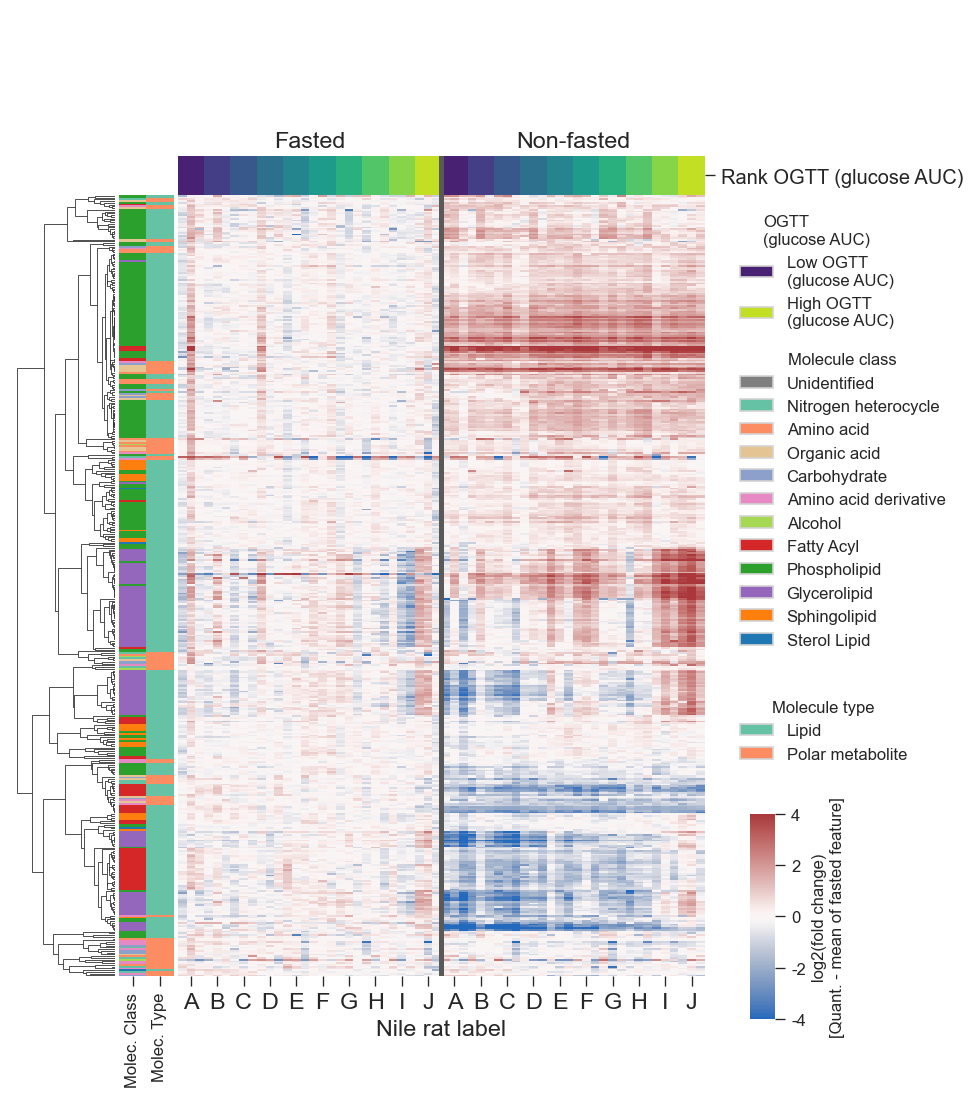

In [130]:
data['Molec. Class'] = data['molec_class'].map(colors)
data['Molec. Type'] = data['Type'].map(colors)
df = data.loc[data['ID'] != 'Unidentified']

rbg_clust = linkage(cm_data.loc[cm_data['bg_type'] == 'RBG', df.index].T, method='complete', metric='cosine')

cm = sns.clustermap(
    data=cm_data[df.index].T,
    row_linkage=rbg_clust, col_cluster=False, 
    row_colors=df[['Molec. Class', 'Molec. Type']], 
    col_colors=cm_data[['animal_color']],
    cmap='vlag', 
    dendrogram_ratio=0.15, 
    colors_ratio=0.04,
#     legend=True,
#     cbar_kws=dict(label='log2(fold change)\n[Quant. - mean of fasted TG]'),
    figsize=(7, 9.5), 
    cbar_pos=(0.9, 0.1, 0.03, 0.18),
    tree_kws={'linewidth': 0.5},
    #### HEATMAP ARGUMENTS #### 
    center=0, vmin=-4, vmax=4,
    yticklabels=False,
)

handles, labels = [], []
for superclass in data['superclass'].unique():
    s_color = colors[superclass]
    labels.append(superclass)
    handles.append(Patch(edgecolor='lightgray', facecolor=s_color))
legend1 = plt.legend(handles, labels, title='Molecule class',
           bbox_to_anchor=(0.88, 0.42), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
cm.fig.add_artist(legend1)

labels = ['Lipid', 'Polar metabolite']
handles = [Patch(facecolor=colors['lipid'], edgecolor='lightgray'), 
           Patch(facecolor=colors['metabolite'], edgecolor='lightgray')]
legend2 = plt.legend(handles, labels, title='Molecule type', 
           bbox_to_anchor=(0.88, 0.32), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
cm.fig.add_artist(legend2)

labels = ['Low OGTT\n(glucose AUC)', 'High OGTT\n(glucose AUC)']
handles = [Patch(facecolor=colors[str(ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].idxmin())], edgecolor='lightgray'), 
           Patch(facecolor=colors[str(ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].idxmax())], edgecolor='lightgray')]
plt.legend(handles, labels, title='OGTT\n(glucose AUC)', 
           bbox_to_anchor=(0.88, 0.70), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))

cm.ax_heatmap.set_xticks(np.arange(1.5, 61, 3), labels='ABCDEFGHIJ'*2, rotation=0, fontsize=14)
cm.ax_heatmap.set_xlabel('Nile rat label', fontsize=14)
cm.ax_heatmap.axvline(   x=30, c='0.35', linewidth=3)
cm.ax_col_colors.axvline(x=30, c='0.35', linewidth=3)

cm.ax_cbar.set_ylabel('log2(fold change)\n[Quant. - mean of fasted feature]', fontsize=10)
cm.ax_col_colors.set_yticklabels(['Rank OGTT (glucose AUC)'], fontsize=12)
cm.ax_col_colors.text(s='Fasted', x=15, y=-0.4, fontsize=14, ha='center', va='center')
cm.ax_col_colors.text(s='Non-fasted', x=45, y=-0.4, fontsize=14, ha='center', va='center')
# cm.fig.suptitle('Title here', fontsize=12)
cm.fig.set_dpi(120)

# plt.savefig('../reports/figures/Figure2/Clustermap.pdf', dpi=150, bbox_inches='tight')
# plt.savefig('../reports/figures/all_TG_plots/TG_heatmap.png', dpi=150, bbox_inches='tight')

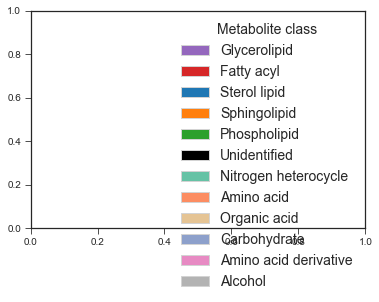

In [475]:
# TESTING LEGENDS 
handles = []
labels = []
for metab, m_color in colors['all_superclass_colors'].items():
    if metab == 'Unidentified':
        m_color = 'black'
    labels.append(metab.capitalize())
    handles.append(Patch(edgecolor='lightgray', facecolor=m_color))

plt.legend(handles, labels, title='Metabolite class', title_fontsize=14, fontsize=14)

## Pie charts from Batch Bakery

In [63]:
lsc = (data  
    .loc[data['Type'] == 'lipid', 'superclass']
    .value_counts()
    .drop('Unidentified')
    .sort_index()
    )
lsc

Fatty Acyl       52
Glycerolipid    109
Phospholipid    173
Sphingolipid     28
Sterol Lipid      4
Name: superclass, dtype: int64

In [60]:
lc = (data  
    .loc[(data['Type'] == 'lipid') & (data['superclass'] != 'Unidentified'), ['molec_class']]
    .value_counts()
    .reset_index()
    )
lc['superclass'] = lc['molec_class'].map(colors)
lc = (lc
    .sort_values('superclass')
    .drop('superclass', axis=1)
    .set_index('molec_class')
    .loc[:, 0]
     )
lc

molec_class
CE                4
PC               62
Plasmanyl-PC     27
LysoPC           20
Plasmenyl-PE     18
PI               15
Plasmenyl-PC     12
Plasmanyl-PE     10
PE                6
LysoPE            3
TG              107
Alkenyl-DG        2
FA               38
AC               14
SM               24
Cer[NS]           4
Name: 0, dtype: int64

In [87]:
# lsc = Lipid Super Classes
lsc = (data  
    .loc[data['Type'] == 'lipid', 'superclass']
    .value_counts()
    .drop('Unidentified')
    .sort_index()
    )
lc = (data  # lc = Lipid Classes
    .loc[(data['Type'] == 'lipid') & (data['superclass'] != 'Unidentified'), 'molec_class']
    .value_counts()
    .to_frame()
     )
lc['superclass'] = lc.index.map(compound_superclasses)
lc = lc.sort_values('superclass')
lc_counts = lc['molec_class']
lc_names = lc.index

mc = (data  # mc = Metabolite Class
    .loc[(data['Type'] == 'metabolite') & (data['ID'] != 'unknown'), 'superclass']
    .value_counts()
    .drop('Unidentified')
    .sort_index()
     )

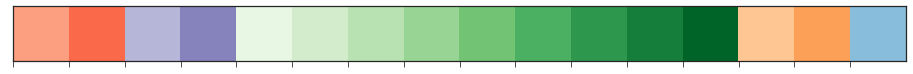

In [119]:
lipid_class_color_gradient = (
    list(sns.color_palette('Reds', 5)[1:3]) +
    list(sns.color_palette('Purples', 4)[1:3]) + 
    list(sns.color_palette('Greens', 9)[::1]) +
    list(sns.color_palette('Oranges', 6)[1:3]) +
    list(sns.color_palette('Blues', 6)[2:3])
)
sns.palplot(lipid_class_color_gradient)

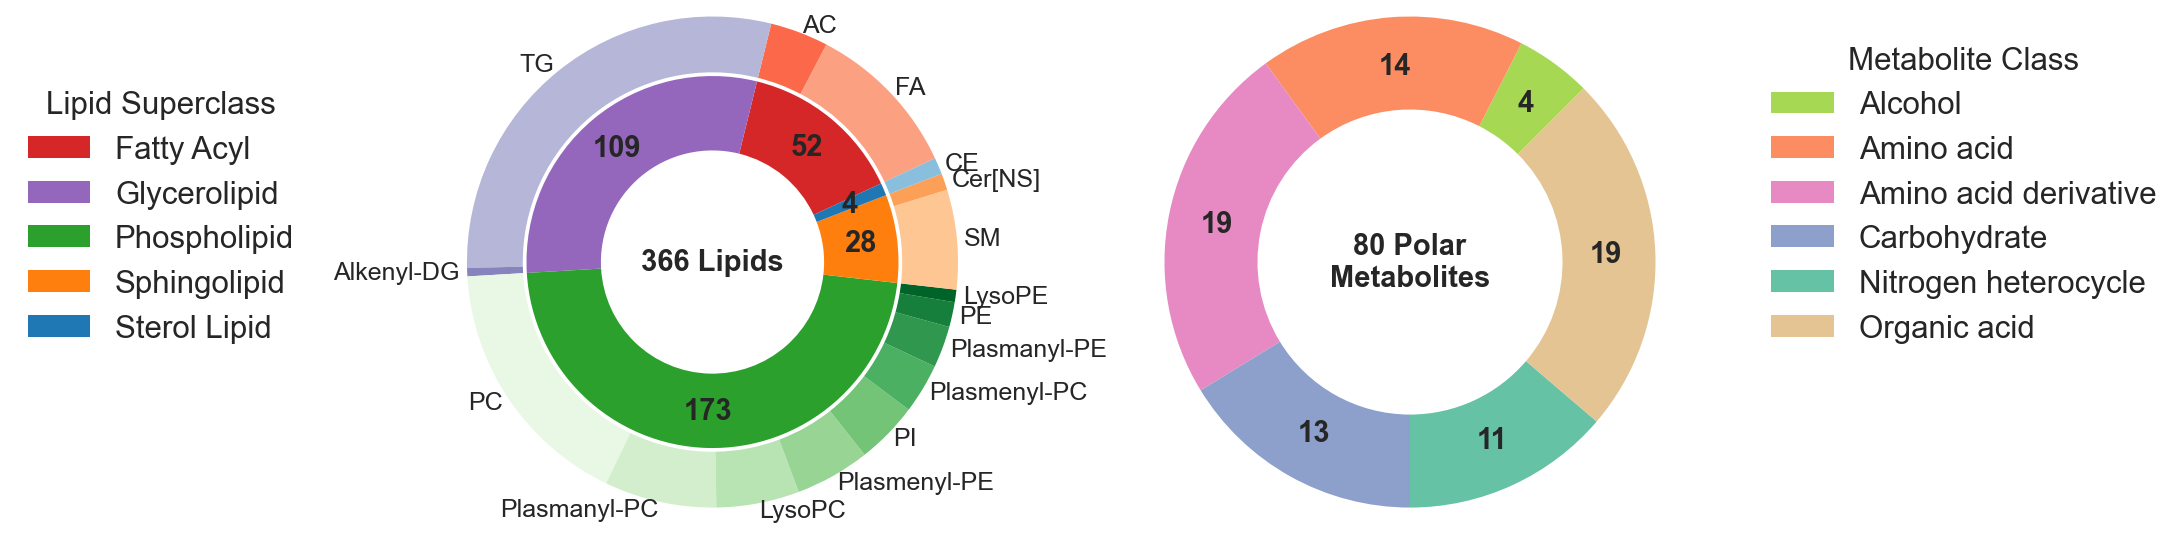

In [120]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5), gridspec_kw={'wspace': 0.5}, dpi=150)
axs[0].set_aspect('equal'), axs[1].set_aspect('equal')
ax = axs[0]
startangle=25
wedges, texts = ax.pie(
    lsc,
#     explode=[0.02]*5,  # expand the slices away from the center
    labels=lsc.index, #lsc.astype('str') + ' ' + lsc.index.astype('str'), 
    labeldistance=0.80,
    colors=lsc.index.map(colors),
    radius=1,
    wedgeprops=dict(width=0.4),
    textprops=dict(fontsize=14, fontweight='bold', ha='center'),
    rotatelabels=False,
    startangle=startangle,
)
[text.set_text(count) for text, count in zip(texts, lsc)]  # Set numbers here, so that legend contains names

ax.legend(loc=(-1, 0.3), fontsize=15, title='Lipid Superclass', title_fontsize=15)
outer_wedges, outer_texts = ax.pie(
    lc_counts,
    labels=lc_names,
    labeldistance=1.03, 
#     explode=[0.05] * len(lc),
    radius=1.32,
    wedgeprops=dict(width=0.3),
#     colors=['gray', 'lightgray'],
    colors=lipid_class_color_gradient,
    textprops=dict(fontsize=12),
    startangle=startangle,
)
ax.text(0, 0, f'{lsc.sum()} Lipids', fontsize=14, fontweight='semibold', ha='center', va='center')

ax = axs[1]
random.seed(5)
m_wedges, m_texts = ax.pie(
    mc,
    labels=mc.index.astype('str').str.capitalize(),
    labeldistance=0.80,
    radius=1.32,
#     colors=sns.color_palette('deep', len(mc), desat=1),
#     colors=random.sample(sns.color_palette('tab10', 11)[5:], 6, ),#[::-1],
#     colors=sns.color_palette('Set2', 12, desat=1)[6:12],#[::-1],
#     colors=sns.color_palette('husl', 6),
    colors=mc.index.map(colors),
    wedgeprops=dict(width=0.5),
    textprops=dict(fontsize=14, fontweight='bold', ha='center', ),
    startangle=45,
)
[text.set_text(count) for text, count in zip(m_texts, mc)]
ax.legend(loc=(1.25, 0.3), fontsize=15, title='Metabolite Class', title_fontsize=15)
ax.text(0, 0, f'{mc.sum()} Polar\nMetabolites', fontsize=14, fontweight='semibold', ha='center', va='center')

plt.savefig('../reports/figures/Figure2/Piecharts.pdf', dpi=150, bbox_inches='tight')

Text(0, 0, '80 Polar\nMetabolites')

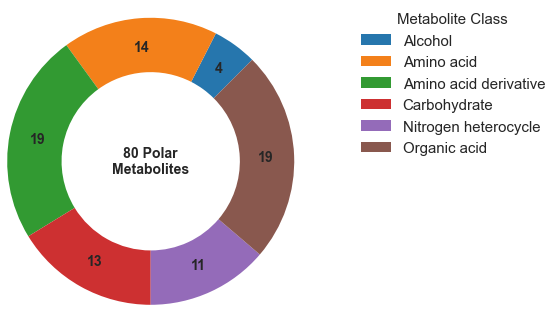

In [114]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect('equal')
m_wedges, m_texts = ax.pie(
    mc,
    labels=mc.index.astype('str').str.capitalize(),
    labeldistance=0.80,
    radius=1.32,
    colors=sns.color_palette('tab10', len(mc), desat=0.9),
    wedgeprops=dict(width=0.5),
    textprops=dict(fontsize=14, fontweight='bold', ha='center', ),
    startangle=45,
)
[text.set_text(count) for text, count in zip(m_texts, mc)]
plt.legend(loc=(1.25, 0.5), fontsize=15, title='Metabolite Class', title_fontsize=15)
ax.text(0, 0, f'{mc.sum()} Polar\nMetabolites', fontsize=14, fontweight='semibold', ha='center', va='center')

# RT/mz plots

<AxesSubplot:xlabel='RT', ylabel='m/z'>

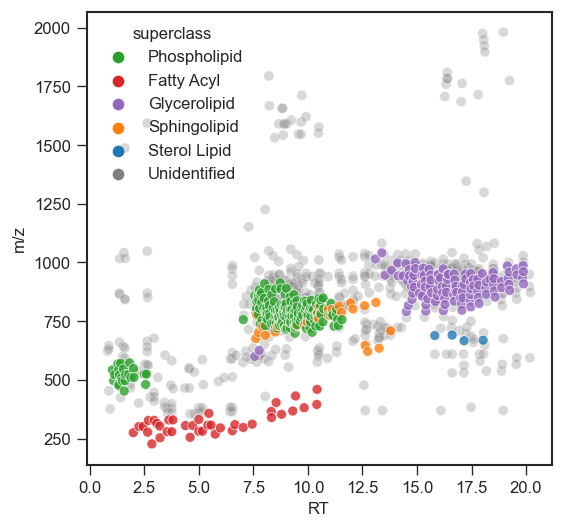

In [100]:
df = data.loc[data['Type'] == 'lipid']
fig, ax = plt.subplots(figsize=(5,5), dpi=120)
sns.scatterplot(
    data=df.loc[(df['superclass'] != 'Unidentified') & (df['molec_class'] != 'AC')],  # remove AC because from HILIC
    x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.8
)
sns.scatterplot(
    data=df.loc[df['superclass'] == 'Unidentified'], x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.3, zorder=-10
)

<AxesSubplot:xlabel='RT', ylabel='m/z'>

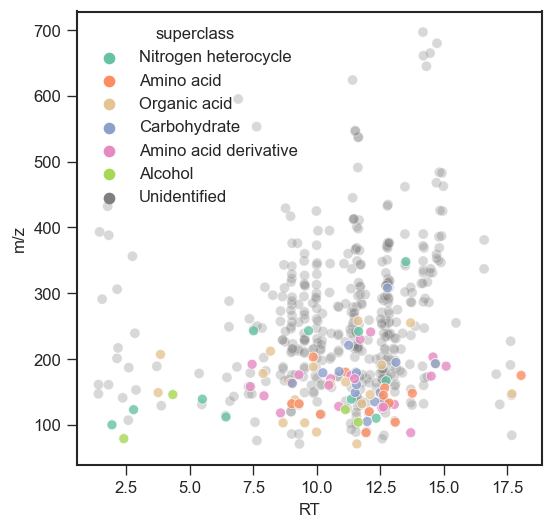

In [101]:
df = data.loc[data['Type'] == 'metabolite']
fig, ax = plt.subplots(figsize=(5,5), dpi=120)
sns.scatterplot(
    data=df.loc[(df['superclass'] != 'Unidentified') & (df['molec_class'] != 'AC')],  # remove AC because from HILIC
    x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.8
)
sns.scatterplot(
    data=df.loc[df['superclass'] == 'Unidentified'], x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.3, zorder=-10
)

In [102]:
df

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,qval_fed,qval_fasted,pval_fed,pval_fasted
i,,,,,,,,,,,,,,,,,,,,,
m_0,Unidentified_2.353_141.0659,Unidentified,141.06591,2.353,Unidentified,metabolite,-,HILIC,Unidentified,18.724636,...,6.107470e-01,0.000223,0.625991,5.498881e-01,2.801501e-05,0.520258,0.005188,0.047076,1.774542e-03,0.005889
m_1,Unidentified_11.539_180.0585,Unidentified,180.05850,11.539,Unidentified,metabolite,-,HILIC,Unidentified,20.779580,...,2.704523e-10,0.002746,0.000131,6.116236e-11,6.111934e-04,0.000003,0.000001,0.563346,3.159016e-08,0.337609
m_2,Urocanic acid_11.365_139.0503,Urocanic acid,139.05028,11.365,Nitrogen heterocycle,metabolite,+,HILIC,Nitrogen heterocycle,24.180859,...,1.839761e-01,0.655652,0.682464,1.412000e-01,5.348448e-01,0.582536,0.559416,0.980767,4.526725e-01,0.955407
m_3,Uridine_7.513_243.0615,Uridine,243.06152,7.513,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,24.887680,...,1.238196e-10,0.085684,0.530633,2.563897e-11,4.002608e-02,0.416631,0.525163,0.115738,4.126169e-01,0.029282
m_4,Uric acid_12.732_167.0201,Uric acid,167.02007,12.732,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,27.518513,...,4.040584e-01,0.040484,0.251925,3.452344e-01,1.625088e-02,0.151978,0.558230,0.073041,4.510871e-01,0.013072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_490,Unidentified_6.857_188.0708,Unidentified,188.07080,6.857,Unidentified,metabolite,-,HILIC,Unidentified,17.634630,...,4.455072e-19,0.236182,0.129122,2.361345e-20,1.387050e-01,0.062885,0.770687,0.193054,6.857205e-01,0.062199
m_491,Unidentified_1.403_161.1325,Unidentified,161.13253,1.403,Unidentified,metabolite,+,HILIC,Unidentified,19.227724,...,7.502939e-01,0.293052,0.016376,7.068140e-01,1.822513e-01,0.003890,0.308081,0.054284,2.148943e-01,0.007442
m_492,Unidentified_8.657_229.0434,Unidentified,229.04342,8.657,Unidentified,metabolite,-,HILIC,Unidentified,21.181276,...,1.117216e-01,0.681286,0.039568,8.148177e-02,5.642878e-01,0.013562,0.294815,0.105230,2.020989e-01,0.024303


In [ ]:
# cm.ax_row_colors.set_xticklabels(['# unsaturations', '# FA carbons'], fontsize=12)
# Unsaturations colorbar
# sm = plt.cm.ScalarMappable(cmap=ListedColormap(unsat_palette))
# sm.set_array(range(0, max_unsats+1))
# unsat_cbar = fig.colorbar(sm, ax=cm.ax_col_dendrogram, orientation='vertical', drawedges=True)
# unsat_cbar.ax.tick_params(labelsize=12)
# unsat_cbar.ax.yaxis.set_label_position('left')
# unsat_cbar.ax.set_ylabel('Num. unsaturations', fontsize=14)

# Carbons colorbar
# sm = plt.cm.ScalarMappable(cmap=ListedColormap(carbons_palette))
# sm.set_array(range(min_carbons, max_carbons))
# carbons_cbar = fig.colorbar(sm, ax=cm.ax_col_dendrogram, orientation='vertical', drawedges=True)
# carbons_cbar.ax.tick_params(labelsize=12)
# # unsat_cbar.ax.yaxis.set_label_position('left')
# carbons_cbar.ax.set_ylabel('Num. carbons', fontsize=14)